# Session 9 Part 2: Relaxation Method to solve spatial PDEs

In [4]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import mlab

import time
from IPython import display

---

# 2D Partial Differential Equations

Many problems in Geosciences can be represented as
    Partial Differential Equations (PDEs).

For example, the time evolving advection-diffusion of pollution away from a chimney.

![Air pollution](https://breakingenergy.com/wp-content/uploads/sites/2/2013/12/181753791.jpg)
**Figure 1: Advection-diffusion of pollution away from a chimney.**


- In some cases analytical solutions can be found.
- In many cases there are no analytical solutions!
- So we need to solve numerically.

Other examples include:

- Oceanic and atmospheric flow for weather forecasting and climate projection,
- Ice-sheet dynamics,
- Mantle Convection,
- The movement of sea-ice in the ocean.


 Aim of this session is to outline some approaches to
    numerically modelling simple PDEs.

---

In [5]:
from scipy import sparse
import scipy.sparse.linalg as linalg   # linear algebra for sparse systems

def createSecondOrderDiffMatrix_d2y_dx2(N, h):
    M_SecondOrderTerm = ( -2*sparse.eye(N,N,0) + sparse.eye(N,N,1) + sparse.eye(N,N,-1) ) / h**2
    return M_SecondOrderTerm
    
def createFirstOrderDiffMatrix_dy_dx(N, h):
    M_FirstOrderTerm = ( sparse.eye(N,N,1) - sparse.eye(N,N,-1) ) / (2*h)
    return M_FirstOrderTerm
    
def returnDiagonalMatrixFor_y(N):
    M_forY = sparse.eye(N,N,0)
    return M_forY

## 4 The Laplacian


In this Session, we focus entirely on three problems which
    include,

- the Laplacian operator ($\nabla^2 \equiv \nabla\cdot\nabla \equiv \Delta$) 
- and work in 1 & 2-D Cartesian co-ordinates.

Many problems are best solved by working in co-ordinate systems that respect the symmetry of the problem. For example spherical co-ordinates are a natural co-ordinate system when working with the Earth.

But we'll just focus on Cartesian co-ordinates where
- The Laplacian in 2D Cartesian co-ordinates is $$\nabla^2 =
  \frac{\partial^2}{\partial x^2}+\frac{\partial^2}{\partial y^2}$$


The first thing we need to do is represent $\nabla^2$ in a discretised form, $\nabla^2_h$. 

The subscript $h$ is just to show we have discretised across steps of size $h$.

---

## Discretising the Laplacian in 2D

In 2D, the Laplacian has 2 terms,

$$\nabla^2 = \frac{\partial^2}{\partial x^2}+\frac{\partial^2}{\partial y^2}$$

which we can discretises into separate $x$ and $y$ terms,

$$ \nabla^2_h u(x,y)=\frac{u(x+h,y)-2u(x,y)+u(x-h,y)}{h^2}+ \frac{u(x,y+h)-2u(x,y)+u(x,y-h)}{h^2} $$

In this example we have assumed that the spatial step sizes are the same in the $x$ and $y$ directions. i.e. $dx=dy=h$.

By grouping like terms, this reduces to a form that can be put into a banded matrix:
  
$$ h^2 \nabla^2_h u(x,y)=u(x+h,y)+u(x,y+h)-4u(x,y)+ u(x-h,y)+u(x,y-h) $$

## 4.1 EXAMPLE: Solving the Laplace Equation $\nabla^2 \phi = 0$ using the relaxation method

$$ h^2 \nabla^2_h u(x,y)=u(x+h,y)+u(x,y+h)-4u(x,y)+ u(x-h,y)+u(x,y-h) =0$$

Since the RHS is zero, we can rearrange this to:

$$u(x,y) = \frac{1}{4} \left( u(x+h,y)+u(x,y+h)-)+ u(x-h,y)+u(x,y-h) \right)$$

So Poisson's equation just means that each value is an average of the adjacent values.

Consider the problem where we have a metal sheet where 3 sides are held at zero volts and the top edge is held at a finite voltange, $V$.

In this problem, we know the voltages along all boundaries.

Since we are looking for a steady state solution, we can find the final field by repeatedly averaging the values in adjacent cells, whilst holding the boundary values constant, until the resulting field is stable.

<img src="http://www-personal.umich.edu/~mejn/cp/figures/fig9-2.png" width=30%>


KeyboardInterrupt: 

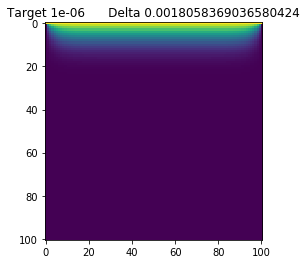

In [10]:
# Constants
M = 100         # Grid squares on a side
V = 1.0         # Voltage at top wall
target = 1e-6   # Target accuracy

# Create arrays to hold potential values
phi = np.zeros([M+1,M+1],float)
phi[0,:] = V
phiprime = np.empty([M+1,M+1],float)

useAnimation = True

# Main loop
delta = 1.0
n=0
while delta>target:

    # Calculate new values of the potential
    phiprime = np.copy(phi)
    phi[1:-1,1:-1] = 0.25*(phiprime[0:-2,1:-1]+phiprime[1:-1,0:-2]+phiprime[2:,1:-1]+phiprime[1:-1,2:])

    # Calculate maximum difference from old values
    delta = np.max( np.abs(phi-phiprime) )
    n = n+1

    if(useAnimation):
        plt.imshow(phi, hold=False)
        plt.title("Target "+str(target)+ "      Delta "+str(delta))
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.001) # necessary to get the plot up.


    
print("This took ", n, "timesteps")

# Make a plot
plt.imshow(phi)
plt.colorbar()


## 4.2 EXERCISE:  Solving Poisson's Equation $\nabla^2 \phi = -\frac{\rho}{\epsilon_0}$ using the relaxation method

Start with the disctretisation

$$ \nabla^2_h u(x,y)= \frac{u(x+h,y)+u(x,y+h)-4u(x,y)+ u(x-h,y)+u(x,y-h)}{h^2} = -\frac{\rho(x,y)}{\epsilon_0}$$

modify the relaxation code for the Laplace equation so solve the problem where the are two square charges placed inside a 2D square box. The potential is zero on all the walls and the carge densities are +1Cm$^{-1}$ and -1Cm$^{-1}$.

<img src="http://www-personal.umich.edu/~mejn/cp/figures/fig9-4.png" width=30%>

Work in units where $\epsilon_0=1$ and iterate until the difference between successive updates is less than $10^{-6}$V everywhere.

The solution should look like:

<img src="http://www-personal.umich.edu/~mejn/cp/figures/fig9-5.png" width=30%>


This took  9219 timesteps


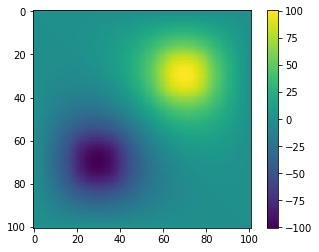

In [25]:
### MODIFY THE CODE BELOW

# Constants
M = 100         # Grid squares on a side
target = 1e-6   # Target accuracy

# Create arrays to hold potential values
phi = np.zeros([M+1,M+1],float)
phiprime = np.empty([M+1,M+1],float)

# Main loop
delta = 1.0
n=0

while delta>target:
    # Calculate new values of the potential
    phiprime = np.copy(phi)
    phi[1:-1,1:-1] = ...
    
    # Since, parameter choices mean rho = 1, A_cell=1, epzilon_0=1
    phi[ ... : ... , ... : ... ] -= ...
    phi[ ... : ... , ... : ... ] += ...
    
    # Calculate maximum difference from old values
    delta = np.max( np.abs( ... - ... ))
    n = n+1

print("This took ", n, "timesteps")

# Make a plot
plt.imshow(phi)
plt.colorbar()

KeyboardInterrupt: 

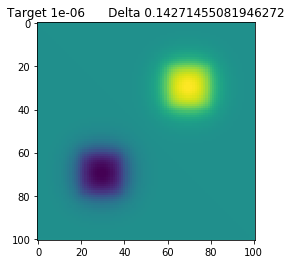

In [11]:
## MY SOLUTION

from numpy import empty,zeros,max

useAnimation = True

# Constants
M = 100         # Grid squares on a side
target = 1e-6   # Target accuracy

# Create arrays to hold potential values
phi = zeros([M+1,M+1],float)
phiprime = empty([M+1,M+1],float)

# Main loop
delta = 1.0
n=0
while delta>target:

    # Calculate new values of the potential
    phiprime = np.copy(phi)
    phi[1:-1,1:-1] = 0.25*(phiprime[0:-2,1:-1]+phiprime[1:-1,0:-2]+phiprime[2:,1:-1]+phiprime[1:-1,2:])
    
    # Since, parameter choices mean rho = 1, A_cell=1, epzilon_0=1
    phi[60:80,20:40] -= 0.25
    phi[20:40,60:80] += 0.25
    
    # Calculate maximum difference from old values
    delta = max(abs(phi-phiprime))
    n = n+1
    
    if(useAnimation):
        plt.imshow(phi, hold=False)
        plt.title("Target "+str(target)+ "      Delta "+str(delta))
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.001) # necessary to get the plot up.



print("This took ", n, "timesteps")

# Make a plot
plt.imshow(phi)
plt.colorbar()



# When to use banded matrices and when to use relaxation method?

- Banded matrices work on linear problems
- Relaxation methods are slower but also work on non-linear problems!!